In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import BayesianRidge
from sklearn.datasets import make_regression
import seaborn as sns

In [2]:
df = pd.read_excel("Data.xlsx", parse_dates = ["Day", "Starts", "Ends"])

In [3]:
df["Engagement Rate"] = (df['Engagements']/df['Impressions'])*100
df["o.CTR"] = (df['Outbound clicks']/df['Impressions'])
df["VTR"] = (df['3-second video plays']/df['Impressions'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21717 entries, 0 to 21716
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Campaign ID                   21717 non-null  float64       
 1   Campaign name                 21717 non-null  object        
 2   Ad set ID                     21717 non-null  float64       
 3   Ad set name                   21717 non-null  object        
 4   Ad ID                         21717 non-null  float64       
 5   Ad name                       21717 non-null  object        
 6   Platform                      21717 non-null  object        
 7   Placement                     21717 non-null  object        
 8   Day                           21717 non-null  datetime64[ns]
 9   Objective                     21717 non-null  object        
 10  Reach                         21717 non-null  int64         
 11  Impressions                 

In [5]:
df.head().T

,0,1,2,3,4
Campaign ID,23847773099000100.0,23847773099000100.0,23847773099000100.0,23847773099000100.0,23847773099000100.0
Campaign name,[05703]MK~fr_AR~ZEN_MB~lanc_CN~Summer_CP~33010...,[05703]MK~fr_AR~ZEN_MB~lanc_CN~Summer_CP~33010...,[05703]MK~fr_AR~ZEN_MB~lanc_CN~Summer_CP~33010...,[05703]MK~fr_AR~ZEN_MB~lanc_CN~Summer_CP~33010...,[05703]MK~fr_AR~ZEN_MB~lanc_CN~Summer_CP~33010...
Ad set ID,23847773099090100.0,23847773099090100.0,23847773110050100.0,23847773110050100.0,23847773110050100.0
Ad set name,AS~FBINSTA_LG~FR_TG~BHV_TS~F2549_SA~FBIG Engag...,AS~FBINSTA_LG~FR_TG~BHV_TS~F2549_SA~FBIG Engag...,AS~FBINSTA_LG~FR_TG~BHV_TS~F2549_SA~Website Vi...,AS~FBINSTA_LG~FR_TG~BHV_TS~F2549_SA~Website Vi...,AS~FBINSTA_LG~FR_TG~BHV_TS~F2549_SA~Website Vi...
Ad ID,23847859745950100.0,23847859764810100.0,23847829176470100.0,23847773158020100.0,23847773158020100.0
Ad name,FM~CRL_SZ~1X1_LG~FR_DU~RET_FF~Carousel 3_PI~NA...,FM~IMLINKAD_SZ~1X1_LG~FR_DU~RET_FF~Influencer_...,FM~IMLINKAD_SZ~1X1_LG~FR_DU~RET_FF~Influencer_...,FM~IMLINKAD_SZ~1X1_LG~FR_DU~RET_FF~Link Ad 3_P...,FM~IMLINKAD_SZ~1X1_LG~FR_DU~RET_FF~Link Ad 3_P...
Platform,facebook,facebook,facebook,facebook,instagram
Placement,feed,feed,feed,feed,feed
Day,2021-07-31 00:00:00,2021-07-31 00:00:00,2021-07-31 00:00:00,2021-07-31 00:00:00,2021-07-31 00:00:00
Objective,LINK_CLICKS,LINK_CLICKS,LINK_CLICKS,LINK_CLICKS,LINK_CLICKS


## Selection of Qualitative variables and preparing the dataset

In [6]:
df_quali = df[["Phase","Campaign","Market","Target","Age","Gender"]]
df_quali.nunique()

Phase        4
Campaign    43
Market       8
Target       7
Age         26
Gender       3
dtype: int64

In [7]:
df_quali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21717 entries, 0 to 21716
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Phase     21717 non-null  object
 1   Campaign  21717 non-null  object
 2   Market    21717 non-null  object
 3   Target    21717 non-null  object
 4   Age       21717 non-null  object
 5   Gender    21717 non-null  object
dtypes: object(6)
memory usage: 1018.1+ KB


In [8]:
df_quali_1 = pd.get_dummies(df_quali)

## Selection of Quantitative variables

In [9]:
df_quanti = df[df.columns[df.dtypes !="object"]]
df_quanti.info()
df_quanti.drop(columns=["Campaign ID","Ad set ID","Ad ID","Day","Starts","Ends"], inplace=True)
df_quanti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21717 entries, 0 to 21716
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Campaign ID                   21717 non-null  float64       
 1   Ad set ID                     21717 non-null  float64       
 2   Ad ID                         21717 non-null  float64       
 3   Day                           21717 non-null  datetime64[ns]
 4   Reach                         21717 non-null  int64         
 5   Impressions                   21717 non-null  int64         
 6   Frequency                     21717 non-null  float64       
 7   Amount spent (EUR)            21717 non-null  float64       
 8   Engagements                   21717 non-null  int64         
 9   Video plays at 25%            21717 non-null  int64         
 10  Video plays at 50%            21717 non-null  int64         
 11  3-second video plays        

C:\Users\Priyanka\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##     Finding the variables associated with frequency

In [10]:
y = (df_quanti["Frequency"])
df_test = pd.concat([df_quali_1,df_quanti], axis=1).drop(columns="Frequency")

In [11]:
dt = DecisionTreeRegressor()
X_train, X_test, y_train, y_test = train_test_split(df_test, y, test_size= 0.2, 
                                                    shuffle=True, random_state = 42)
dt.fit(X_train, y_train)
r2_score(y_test, dt.predict(X_test))

0.9705340990790372

In [12]:
rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train,y_train)
r2_score(y_test, rf.predict(X_test))

0.9878697719290829

In [13]:
df_imp = pd.DataFrame({"Features":df_test.columns, "importance":100*rf.feature_importances_/max(rf.feature_importances_)
                      }).sort_values("importance", ascending=False)

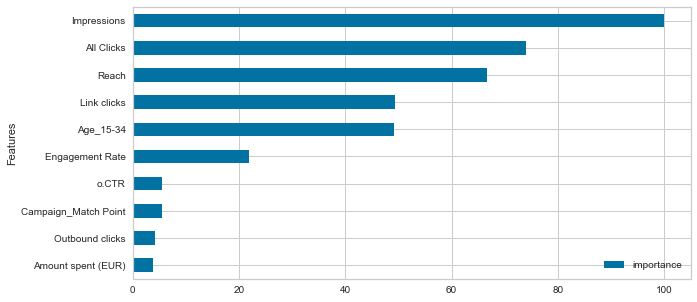

In [14]:
df_imp[:10].sort_values("importance", ascending=True).plot.barh(x="Features", y="importance", figsize=(10,5));

## Predicting the number of clusters

In [15]:
full_features = df_imp["Features"][:10].to_list()
df_full = df_test[full_features]
df_full["Frequency"] = df_quanti["Frequency"]

C:\Users\Priyanka\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
scaler = StandardScaler()

In [17]:
data_scaled = scaler.fit_transform(df_full)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

# fitting multiple k-means algorithms and storing the values in an empty list
Inertia = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(df_full)
    Inertia.append(kmeans.inertia_)

C:\Users\Priyanka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\Priyanka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\Priyanka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\Priyanka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
C:\Users\Priyanka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [18]:
print(len(kmeans.cluster_centers_))

19


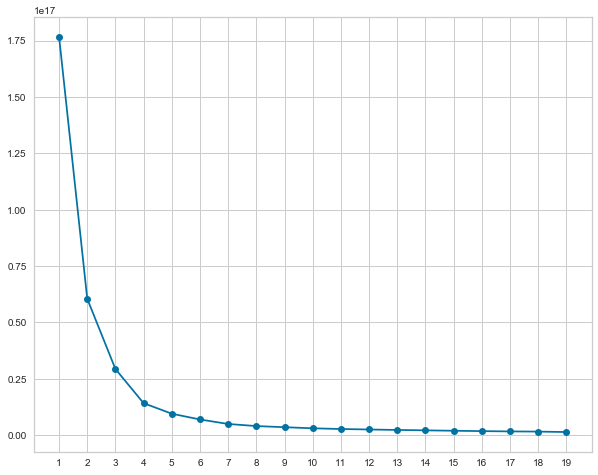

In [19]:
plt.figure(figsize=(10,8))
x = list(range(1,20))
y = Inertia
plt.plot(x,y,marker='o')
plt.xticks(x);

## Elbow Technique to Confirm the actual clusters

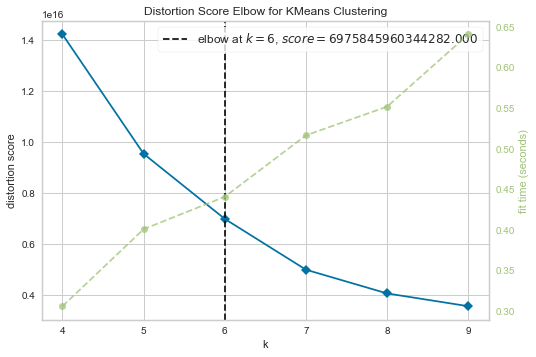

In [20]:
model = KMeans()

visualizer = KElbowVisualizer(model, k=(4,10))

visualizer.fit(df_full)   
visualizer.poof();

In [21]:
kmeans = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

# inertia on the fitted data
kmeans.inertia_

107056.6587540904

In [22]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
df_scale = pd.DataFrame(data_scaled, columns=df_full.columns)

In [24]:
df_scale

,Impressions,All Clicks,Reach,Link clicks,Age_15-34,Engagement Rate,o.CTR,Campaign_Match Point,Outbound clicks,Amount spent (EUR),Frequency
0,-0.363324,-0.003017,-0.511784,0.009810,-0.206235,-0.126205,0.483767,-0.210326,0.164522,-0.133013,1.005142
1,-0.447390,-0.308408,-0.588627,-0.301912,-0.206235,-0.135718,-0.087732,-0.210326,-0.341785,-0.355210,2.332891
2,-0.414285,-0.184563,-0.531824,-0.213991,-0.206235,-0.126351,0.154543,-0.210326,-0.206770,-0.296915,0.167398
3,-0.458332,-0.304186,-0.582550,-0.301912,-0.206235,-0.135718,0.359157,-0.210326,-0.337566,-0.362946,-0.393533
4,-0.461850,-0.325296,-0.587497,-0.299248,-0.206235,-0.135718,1.012180,-0.210326,-0.333347,-0.365897,-0.569618
...,...,...,...,...,...,...,...,...,...,...,...
21712,0.269654,-0.292927,0.784164,-0.307241,-0.206235,-0.128698,-0.365806,-0.210326,-0.346004,-0.336811,-0.344167
21713,0.740140,-0.228190,1.272961,-0.155376,-0.206235,-0.135106,-0.335670,-0.210326,-0.105508,-0.275541,-0.111236
21714,0.740140,-0.323889,1.272961,-0.320562,-0.206235,-0.132658,-0.371240,-0.210326,-0.367101,-0.372170,-0.111236
21715,0.269654,-0.139528,0.784164,-0.008840,-0.206235,-0.134381,-0.259563,-0.210326,0.130768,-0.086223,-0.344167


In [25]:
df_scale["labels"] = kmeans.labels_

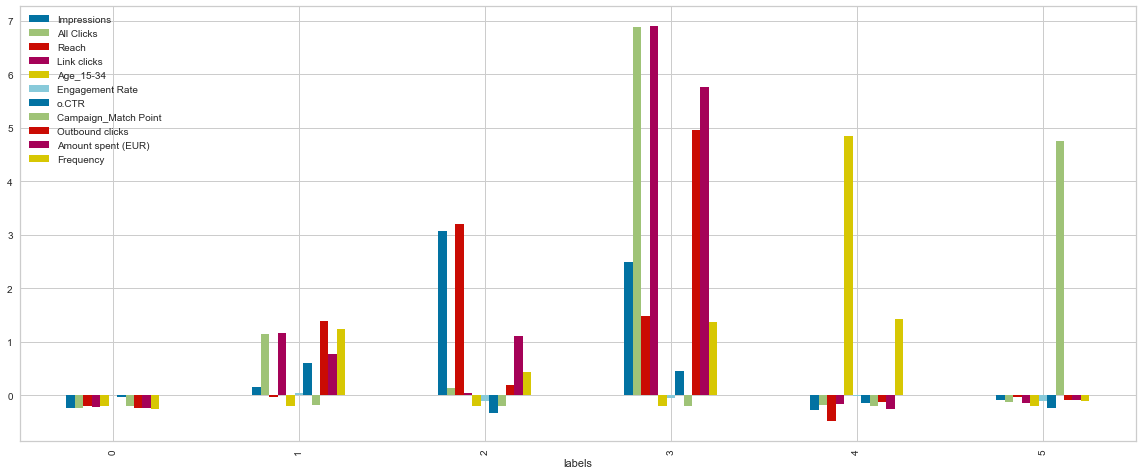

In [26]:
df_scale.groupby("labels").mean().plot(kind="bar", figsize=(20,8));

## Defining the encoder function

In [27]:
def enc(X, y):
    enc = (TargetEncoder([X.columns[X.dtypes =="object"]]))
    enc.fit_transform(X, y)
    return enc

## Testing the function with limited variables

In [28]:
test_prediction_set = pd.concat([df[["Impressions","Reach","Amount spent (EUR)","Phase","Objective","Frequency"]],
                                 df_scale["labels"]], axis=1)

In [29]:
labels = test_prediction_set.loc[(test_prediction_set["labels"] == 3)]
X = labels.drop(columns=["Frequency","labels"])
Y = labels["Frequency"]
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size= 0.2, shuffle=True, random_state = 42)
myEnc = enc(X_train, y_train)

In [30]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
#enc_1 = TargetEncoder([X.columns[X.dtypes =="object"]])
training = myEnc.transform(X_train,y_train)
testing = myEnc.transform(X_test)
regr.fit(training,y_train)
r2_score(y_test, regr.predict(testing))
#result = regr.predict(testing)

0.8528014249648233

In [31]:
labels

,Impressions,Reach,Amount spent (EUR),Phase,Objective,Frequency,labels
3261,6489281,3823594,1847.390000,CONSID,LINK_CLICKS,1.697168,3
3262,8953694,2107369,5463.890000,CONSID,LINK_CLICKS,4.248755,3
3279,5810153,1577713,5827.239921,CONSID,LINK_CLICKS,3.682643,3
3291,14956299,6729700,2649.060000,CONSID,LINK_CLICKS,2.222432,3
3294,3731431,1752821,1890.429846,CONSID,LINK_CLICKS,2.128815,3
...,...,...,...,...,...,...,...
21569,1509824,773878,1144.970000,PURC,LINK_CLICKS,1.950985,3
21574,1509824,773878,1235.890078,PURC,LINK_CLICKS,1.950985,3
21581,1509824,773878,1259.809943,PURC,LINK_CLICKS,1.950985,3
21584,1509824,773878,1216.030054,PURC,LINK_CLICKS,1.950985,3


In [32]:
data = pd.DataFrame([[29944, 3172, 1000.759933, "CONSID", "PURC"]], 
                    columns=['Impressions', 'Reach', 'Amount spent (EUR)', 'Phase', 'Objective'])
dataencoded = myEnc.transform(data)
fre_pred = regr.predict(dataencoded)
print(data, fre_pred)

   Impressions  Reach  Amount spent (EUR)   Phase Objective
0        29944   3172         1000.759933  CONSID      PURC [2.14487465]


## Testing the Model with All the Estimated Variables we have while setting up a campaign

In [33]:
dataset = pd.concat([df[["Age","Target","Phase","Objective","Impressions","Reach","Amount spent (EUR)","Frequency"]],
                     df_scale["labels"]], axis=1)

In [34]:
labels_new = dataset.loc[(dataset["labels"] == 3)]
X_2 = labels_new.drop(columns=["Frequency","labels"])
Y_2 = labels_new["Frequency"]


X_train, X_test, y_train, y_test = train_test_split(X_2, Y_2 , test_size= 0.2, shuffle=True, random_state = 42)
myEnc_2 = enc(X_train, y_train)


rf = RandomForestRegressor(max_depth=2, random_state=0)
#enc_1 = TargetEncoder([X.columns[X.dtypes =="object"]])
training_1 = myEnc_2.transform(X_train,y_train)
testing_2 = myEnc_2.transform(X_test)
rf.fit(training_1,y_train)
r2_score(y_test, rf.predict(testing_2))

result=rf.score(training_1,y_train)
print("score for train set:",result)
result1=rf.score(testing_2,y_test)
print("score for test set:",result1)

score for train set: 0.885192815668077
score for test set: 0.8826396340436664


In [35]:
training_1

,Age,Target,Phase,Objective,Impressions,Reach,Amount spent (EUR)
9507,2.851077,2.774470,4.131594,4.368368,1433501,632832,1063.960000
8091,6.546596,5.464879,4.417839,4.368368,9924237,1641968,1624.711124
7884,6.546596,5.464879,4.417839,4.368368,21569828,2933212,3792.560000
17211,2.851077,2.504837,4.417839,4.368368,2985162,1107947,1872.489991
5367,2.230940,5.464879,4.417839,4.368368,1584042,720007,782.810000
...,...,...,...,...,...,...,...
3447,5.099049,5.464879,4.131594,4.368368,9333623,1808879,3669.360000
10795,2.851077,3.022522,4.417839,4.368368,4408802,1253877,1174.379881
6048,2.230940,3.022522,4.417839,4.368368,1068303,469764,557.000000
8002,6.546596,5.464879,4.417839,4.368368,21569828,2933212,3685.196717


In [36]:
print(dataset.loc[(dataset["Impressions"] == 1258793) & (dataset["Amount spent (EUR)"] == 713.540000)])

        Age              Target Phase    Objective  Impressions   Reach  \
5785  18-49  Demo and Interests  PURC  LINK_CLICKS      1258793  515461   

      Amount spent (EUR)  Frequency  labels  
5785              713.54   2.442072       3  


### Predicting the Optimal Frequency

In [41]:
data = pd.DataFrame({'Age':['16-24'],'Target':['End Users'],'Phase':['CONSID'],'Objective':['ENG'],
                     'Impressions':[22683037],'Reach':[2009609],'Amount spent (EUR)':[80000]})

dataencoded = myEnc_2.transform(data)
fre_pred = rf.predict(dataencoded)
print(data, fre_pred)

     Age     Target   Phase Objective  Impressions    Reach  \
0  16-24  End Users  CONSID       ENG     22683037  2009609   

   Amount spent (EUR)  
0               80000   [3.048629]


In [38]:
df.corr()

,Campaign ID,Ad set ID,Ad ID,Reach,Impressions,Frequency,Amount spent (EUR),Engagements,Video plays at 25%,Video plays at 50%,...,Link clicks,Outbound clicks,All Clicks,Display Measured Impressions,Display Viewable Impressions,Video Measured Impressions,Video Viewable Impressions,Engagement Rate,o.CTR,VTR
Campaign ID,1.000000,0.998631,0.998401,-0.028811,-0.062822,-0.156748,-0.183549,-0.144197,-0.048006,-0.058121,...,-0.211703,-0.145820,-0.191882,0.019978,0.012018,-0.041524,-0.046253,-0.065813,-0.109904,-0.168223
Ad set ID,0.998631,1.000000,0.999678,-0.034362,-0.067273,-0.156777,-0.185948,-0.143186,-0.049122,-0.059089,...,-0.213577,-0.146481,-0.193710,0.018166,0.010280,-0.043313,-0.047282,-0.065232,-0.109506,-0.163713
Ad ID,0.998401,0.999678,1.000000,-0.035884,-0.067596,-0.155294,-0.185051,-0.143502,-0.049459,-0.059278,...,-0.211893,-0.145615,-0.192150,0.018056,0.010238,-0.044193,-0.047792,-0.065407,-0.108724,-0.164360
Reach,-0.028811,-0.034362,-0.035884,1.000000,0.909767,0.100296,0.462756,0.318513,0.467103,0.434055,...,0.200397,0.193990,0.227600,0.079628,0.078038,0.407328,0.302467,-0.063361,-0.151180,-0.025642
Impressions,-0.062822,-0.067273,-0.067596,0.909767,1.000000,0.277570,0.533193,0.260758,0.423282,0.392642,...,0.336061,0.280015,0.352268,0.069338,0.070269,0.335932,0.246598,-0.052228,-0.112216,-0.035136
Frequency,-0.156748,-0.156777,-0.155294,0.100296,0.277570,1.000000,0.290947,0.030487,0.056534,0.063023,...,0.310070,0.319274,0.310039,0.150383,0.136258,0.016575,0.013651,-0.058015,-0.015395,-0.092063
Amount spent (EUR),-0.183549,-0.185948,-0.185051,0.462756,0.533193,0.290947,1.000000,0.354890,0.455147,0.442634,...,0.748740,0.619976,0.752963,0.060497,0.069681,0.176171,0.197861,-0.027104,-0.004036,0.064792
Engagements,-0.144197,-0.143186,-0.143502,0.318513,0.260758,0.030487,0.354890,1.000000,0.527848,0.542169,...,0.317087,0.299540,0.368049,0.076926,0.076876,0.259615,0.459344,0.136093,0.018093,0.143676
Video plays at 25%,-0.048006,-0.049122,-0.049459,0.467103,0.423282,0.056534,0.455147,0.527848,1.000000,0.982784,...,0.246443,0.144321,0.271466,-0.042314,-0.040890,0.482024,0.611670,-0.015456,-0.047823,0.197676
Video plays at 50%,-0.058121,-0.059089,-0.059278,0.434055,0.392642,0.063023,0.442634,0.542169,0.982784,1.000000,...,0.266379,0.154066,0.289922,-0.041998,-0.040585,0.459261,0.613974,-0.014206,-0.043567,0.212127


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 <a list of 24 Text xticklabel objects>)

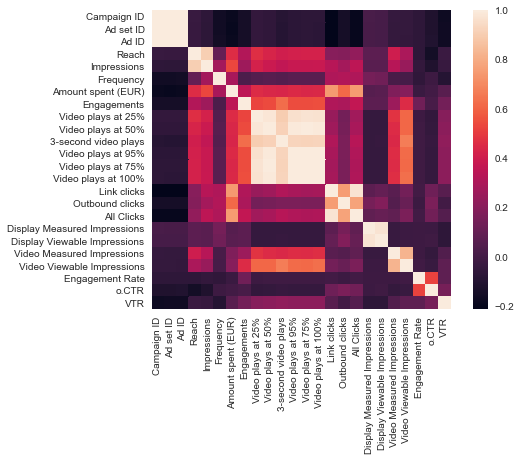

In [39]:
cm = df.corr()
sns.heatmap(cm, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)